In [1]:
from cStringIO import StringIO
import os
import tempfile

import pattern
from pattern.de import parsetree
from discoursegraphs import DiscourseDocumentGraph, EdgeTypes
import discoursegraphs as dg

In [22]:
class PatternDiscourseGraph(DiscourseDocumentGraph):
    """
    represents a plaintext document as a discourse graph
    (parsed with the ``pattern`` library).
    """
    def __init__(self, plaintext_fpath, name=None, namespace='pattern'):
        # super calls __init__() of base class DiscourseDocumentGraph
        super(PatternDiscourseGraph, self).__init__()

        self.name = name if name else os.path.basename(plaintext_fpath)
        with open(plaintext_fpath) as plaintext_file:
            self.parsed = parsetree(plaintext_file.read())

        self.ns = namespace
        self.root = self.ns+':root_node'
        self.add_node(self.root, layers={self.ns}, label=self.ns+':root_node')

        self.sentences = []
        self.tokens = []
        for i, sentence in enumerate(self.parsed):
            self.add_sentence(sentence, i)

    def add_sentence(self, sentence, index):
        token_index = 0
        chunk_index = 0
        sent_id = 'sent_{}'.format(index)
        self.add_node(sent_id, layers={self.ns+':syntax'})
        self.add_edge(self.root, sent_id, edge_type=EdgeTypes.dominance_relation)
        self.sentences.append(sent_id)
        
        for elem in sentence:
            if isinstance(elem, pattern.text.tree.Word):
                self.add_token(elem, index, token_index)
                token_index += 1
            else:  # Chunk
                self.add_chunk(elem, index, chunk_index)
                chunk_index += 1

    def add_token(self, token, sent_index, token_index):
        token_id = 'tok_s{}_{}'.format(sent_index, token_index)
        self.add_node(token_id, layers={self.ns+':token'})
#         raise NotImplementedError
        
    def add_chunk(self, chunk, sent_index, chunk_index):
        raise NotImplementedError
    
    @classmethod
    def from_string(cls, plaintext):
        tfile = tempfile.NamedTemporaryFile(delete=False)
        tfile.write(plaintext)
        tfile.close()
        return cls(tfile.name)

In [23]:
pdg = PatternDiscourseGraph.from_string("Angela Merkel ist gestern in Griechenland gelandet. Bernd ist noch dümmer als Angie.")

In [24]:
for elem in pdg.parsed[1]:
    print type(elem), elem

<class 'pattern.text.tree.Word'> Word(u'Bernd/NN')
<class 'pattern.text.tree.Word'> Word(u'ist/VB')
<class 'pattern.text.tree.Word'> Word(u'noch/IN')
<class 'pattern.text.tree.Word'> Word(u'd\xfcmmer/NN')
<class 'pattern.text.tree.Word'> Word(u'als/IN')
<class 'pattern.text.tree.Word'> Word(u'Angie/NN')
<class 'pattern.text.tree.Word'> Word(u'./.')


In [25]:
ist = pdg.parsed[0][2]

In [26]:
s0 = pdg.parsed[0]

In [27]:
s0.constituents()

[Chunk('Angela Merkel/NP'),
 Chunk('ist/VP'),
 Chunk('gestern/ADVP'),
 Chunk('in/PP'),
 Chunk('Griechenland/NP'),
 Word(u'gelandet/RP'),
 Word(u'./.')]

In [28]:
s0.lemmata

[None, None, None, None, None, None, None, None]

In [29]:
for elem in s0.constituents()[0]:
    print elem

Word(u'Angela/NNP')
Word(u'Merkel/NNP')


In [32]:
# %load_ext gvmagic

In [33]:
# %dotstr dg.print_dot(pdg)

In [12]:
for elem in parsetree("Der 1. FC Wuppertal hat 3:0 verloren.")[1]:
    print elem

Word(u'FC/NN')
Word(u'Wuppertal/NNP')
Word(u'hat/VB')
Word(u'3:0/CD')
Word(u'verloren/JJ')
Word(u'./.')


In [13]:
s = parsetree(
    "Der SV Werder Bremen hat gestern 3:0 auf dem Feld verloren. Angela Merkel interressiert das nicht.",
    relations=True, lemmata=True)

In [14]:
for sent in s:
    for constituent in sent.constituents(pnp=True):
        print constituent
        if isinstance(constituent, pattern.text.tree.Chunk):
            print '\t', [elem for elem in constituent]
        
#     for chunk in sent.chunks:
#         print chunk.type, [(w.string, w.type) for w in chunk.words]
    print

Chunk('Der SV Werder Bremen/NP-SBJ-1')
	[Word(u'Der/DT'), Word(u'SV/PRP$'), Word(u'Werder/NN'), Word(u'Bremen/NN')]
Chunk('hat/VP-1')
	[Word(u'hat/VB')]
Chunk('gestern/ADVP')
	[Word(u'gestern/RB')]
Word(u'3:0/CD')
Chunk('auf dem Feld/PNP')
	[Word(u'auf/IN'), Word(u'dem/DT'), Word(u'Feld/NN')]
Chunk('verloren/ADJP')
	[Word(u'verloren/JJ')]
Word(u'./.')

Chunk('Angela Merkel interressiert/NP')
	[Word(u'Angela/NNP'), Word(u'Merkel/NNP'), Word(u'interressiert/NNP')]
Word(u'das/DT')
Chunk('nicht/ADVP')
	[Word(u'nicht/RB')]
Word(u'./.')



In [15]:
print s[0].xml

<sentence id="5" token="word, part-of-speech, chunk, preposition, relation, lemma" language="de">
	<chunk type="NP" relation="SBJ" of="5.1">
		<word type="DT" lemma="der">Der</word>
		<word type="PRP$" lemma="sv">SV</word>
		<word type="NN" lemma="werder">Werder</word>
		<word type="NN" lemma="bremen">Bremen</word>
	</chunk>
	<chunk type="VP" id="5.1">
		<word type="VB" lemma="haben">hat</word>
	</chunk>
	<chunk type="ADVP">
		<word type="RB" lemma="gestern">gestern</word>
	</chunk>
	<chink>
		<word type="CD" lemma="3:0">3:0</word>
	</chink>
	<chunk type="PNP">
		<chunk type="PP">
			<word type="IN" lemma="auf">auf</word>
		</chunk>
		<chunk type="NP">
			<word type="DT" lemma="dem">dem</word>
			<word type="NN" lemma="feld">Feld</word>
		</chunk>
	</chunk>
	<chunk type="ADJP">
		<word type="JJ" lemma="verlor">verloren</word>
	</chunk>
	<chink>
		<word type="." lemma=".">.</word>
	</chink>
</sentence>


In [16]:
sent = s[0]

In [17]:
sent.relations

{'OBJ': {},
 'SBJ': {1: Chunk('Der SV Werder Bremen/NP-SBJ-1')},
 'VP': {1: Chunk('hat/VP-1')}}

In [18]:
c = sent.relations['SBJ'][1]

In [19]:
c.sentence

Sentence('Der/DT/B-NP/O/NP-SBJ-1/der SV/PRP$/I-NP/O/NP-SBJ-1/sv Werder/NN/I-NP/O/NP-SBJ-1/werder Bremen/NN/I-NP/O/NP-SBJ-1/bremen hat/VB/B-VP/O/VP-1/haben gestern/RB/B-ADVP/O/O/gestern 3:0/CD/O/O/O/3:0 auf/IN/B-PP/B-PNP/O/auf dem/DT/B-NP/I-PNP/O/dem Feld/NN/I-NP/I-PNP/O/feld verloren/JJ/B-ADJP/O/O/verlor ././O/O/O/.')

In [20]:
sent.pnp

[Chunk('auf dem Feld/PNP')]

In [21]:
pattern.text.tree.nltk_tree(sent)

NameError: Use Tree.read(s, remove_empty_top_bracketing=True) instead.

In [40]:
hans_kennt_maria = parsetree("Hans kennt Maria.", relations=True)

In [45]:
# Signature: pattern.text.tree.nltk_tree(sentence)

from nltk.tree import Tree
from pattern.text import Chink

def nltk_tree(sentence):
    """ Returns an NLTK nltk.tree.Tree object from the given Sentence.
        The NLTK module should be on the search path somewhere.
    """
    def do_pnp(pnp):
        # Returns the PNPChunk (and the contained Chunk objects) in NLTK bracket format.
        s = ' '.join([do_chunk(ch) for ch in pnp.chunks])
        return '(PNP %s)' % s
    
    def do_chunk(ch):
        # Returns the Chunk in NLTK bracket format. Recurse attached PNP's.
        s = ' '.join(['(%s %s)' % (w.pos, w.string) for w in ch.words])
        s+= ' '.join([do_pnp(pnp) for pnp in ch.attachments])
        return '(%s %s)' % (ch.type, s)
    
    T = ['(S']
    v = [] # PNP's already visited.
    for ch in sentence.chunked():
        if not ch.pnp and isinstance(ch, Chink):
            T.append('(%s %s)' % (ch.words[0].pos, ch.words[0].string))
        elif not ch.pnp:
            T.append(do_chunk(ch))
        #elif ch.pnp not in v:
        elif ch.pnp.anchor is None and ch.pnp not in v:
            # The chunk is part of a PNP without an anchor.
            T.append(do_pnp(ch.pnp))
            v.append(ch.pnp)
    T.append(')')
    tree_string = ' '.join(T)
    return Tree.fromstring(tree_string)


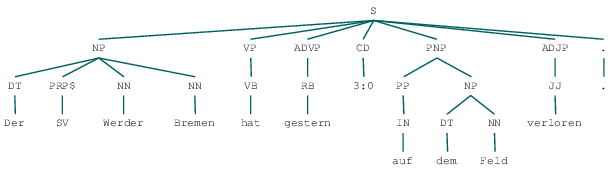

In [46]:
nltk_tree(sent)

In [47]:
sent.relations

{'OBJ': {},
 'SBJ': {1: Chunk('Der SV Werder Bremen/NP-SBJ-1')},
 'VP': {1: Chunk('hat/VP-1')}}

In [48]:
sent.chunked()

[Chunk('Der SV Werder Bremen/NP-SBJ-1'),
 Chunk('hat/VP-1'),
 Chunk('gestern/ADVP'),
 Chink('3:0/O'),
 Chunk('auf/PP'),
 Chunk('dem Feld/NP'),
 Chunk('verloren/ADJP'),
 Chink('./O')]

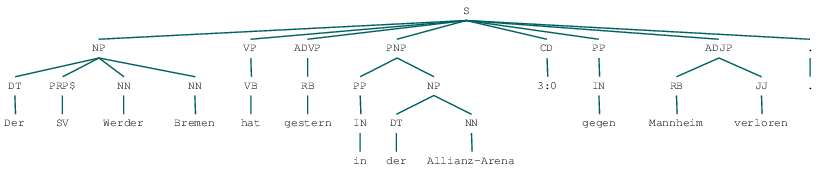

In [51]:
parsed = parsetree("Der SV Werder Bremen hat gestern in der Allianz-Arena 3:0 gegen Mannheim verloren.")
sent0 = parsed[0]

nltk_tree(sent0)

In [52]:
sent0.relations

{'OBJ': {}, 'SBJ': {}, 'VP': {None: Chunk('hat/VP')}}